# Gensim LDA

In [2]:
# import base packages
import re
import numpy as np
import json
import pandas as pd
from pprint import pprint
from tqdm import tqdm
import time

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import plotly.graph_objs as go
import plotly.offline as py
import pyLDAvis
from pyLDAvis import PreparedData
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

In [3]:
def print_time(time):
    print(str(time//60//60)+':'+str(time//60%60)+':'+str(time%60), end='\n')

In [4]:
import pickle
pmc_entire_sample = pickle.load(open('saved_output/processed_corpus/pmc_entire_sample.pkl', 'rb'))

In [5]:
# extract the text from the dictionary to create a list of lists corpus
bodies = [pmc_entire_sample[i]['body'] for i in range(len(pmc_entire_sample))]
len(bodies)

19664

In [6]:
# Create the Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(bodies)

# Create Corpus
texts = bodies

# Term Document Frequency and ID of each feature
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1]);

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 2), (12, 1), (13, 1), (14, 2), (15, 4), (16, 3), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 9), (23, 1), (24, 1), (25, 4), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 4), (35, 1), (36, 1), (37, 1), (38, 2), (39, 4), (40, 5), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 2), (47, 4), (48, 1), (49, 1), (50, 4), (51, 1), (52, 13), (53, 3), (54, 2), (55, 1), (56, 1), (57, 2), (58, 6), (59, 2), (60, 1), (61, 1), (62, 1), (63, 3), (64, 1), (65, 2), (66, 1), (67, 5), (68, 1), (69, 3), (70, 2), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 2), (92, 1), (93, 3), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 1), (105, 4), (106, 2), (107, 2), (108, 1), (109, 1), (110, 2

In [7]:
# corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]];

In [8]:
n_topics_1 = list(range(4,33,4))
n_topics_2 = list(range(36,65,4))

In [9]:
# Build LDA model with different num_topics
def lda_models_iterations(n_topics, id2word, corpus):
    lda_models = {}
    for n in tqdm(n_topics):
        start_t = time.time()
        lda_models['n_t_'+str(n)] = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,id2word=id2word, num_topics=n, random_state=81, workers=3, chunksize=100, passes=10, alpha='asymmetric', iterations =2, per_word_topics=True)
        end_t = time.time()
        elapsed_t = end_t- start_t
        print(str(int(elapsed_t)//60//60)+':'+str(int(elapsed_t)//60%60)+':'+str(int(elapsed_t)%60), end='\n')
    return lda_models

In [10]:
# lda_models_1 = lda_models_iterations(n_topics_1, id2word, corpus)
# pre-saved models can be loaded here
# pickle.dump(lda_models_1, open('saved_output/lda_models/lda_models_1.pkl', 'wb'))
lda_models_1 = pickle.load(open('saved_output/lda_models/lda_models_1.pkl', 'rb'))

In [11]:
# lda_models_2 = lda_models_iterations(n_topics_2, id2word, corpus)
# pre-saved models can be loaded here
# pickle.dump(lda_models_2, open('saved_output/lda_models/lda_models_2.pkl', 'wb'))
lda_models_2 = pickle.load(open('saved_output/lda_models/lda_models_2.pkl', 'rb'))

In [12]:
# source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# calculate coherence_vals with Different num_topics
def calculate_coherence_vals(lda_models, n_topics, bodies, id2word):
    lda_model_list = [v for k,v in lda_models.items()]
    coherence_vals = []
    for lda_model in tqdm(lda_model_list):
        coherence_model_lda = CoherenceModel(model=lda_model, texts=bodies, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_vals.append(coherence_lda)
    num_topics = n_topics
    vals_diff_topics = {'num_topics':num_topics, 'coherence_vals':coherence_vals}
    vals_diff_topics_df = pd.DataFrame(vals_diff_topics)
    print(vals_diff_topics_df)

    return coherence_vals, vals_diff_topics_df

In [13]:
# coherence_vals_1, vals_diff_topics_df_1 = calculate_coherence_vals(lda_models_1, n_topics_1, bodies, id2word)
# # Save output and Load pre-saved coherence score results
# pickle.dump(vals_diff_topics_df_1, open('saved_output/coherence/vals_diff_topics_df_1.pkl', 'wb'))
# pickle.dump(coherence_vals_1, open('saved_output/coherence/coherence_vals_1.pkl', 'wb'))
coherence_vals_1 = pickle.load(open('saved_output/coherence/coherence_vals_1.pkl', 'rb'))
vals_diff_topics_df_1 = pickle.load(open('saved_output/coherence/vals_diff_topics_df_1.pkl', 'rb'))

In [14]:
# coherence_vals_2, vals_diff_topics_df_2 = calculate_coherence_vals(lda_models_2, n_topics_2, bodies, id2word)
# # Save output and Load pre-saved coherence score results
# pickle.dump(vals_diff_topics_df_2, open('saved_output/coherence/vals_diff_topics_df_2.pkl', 'wb'))
# pickle.dump(coherence_vals_2, open('saved_output/coherence/coherence_vals_2.pkl', 'wb'))
coherence_vals_2 = pickle.load(open('saved_output/coherence/coherence_vals_2.pkl', 'rb'))
vals_diff_topics_df_2 = pickle.load(open('saved_output/coherence/vals_diff_topics_df_2.pkl', 'rb'))

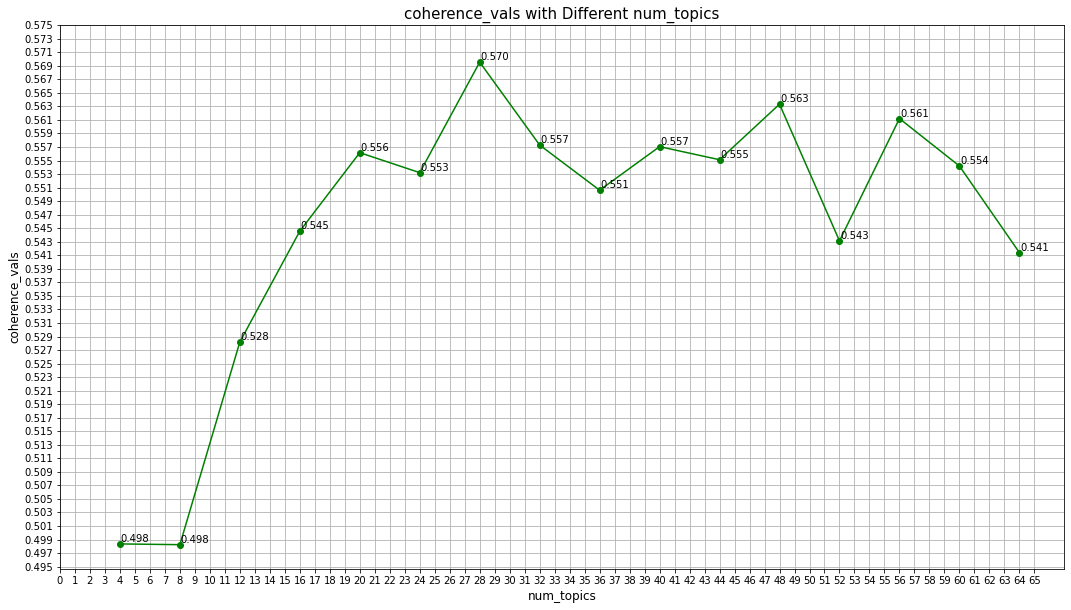

In [15]:
# source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# plot coherence_vals with Different num_topics
xs = np.r_[np.array(n_topics_1), np.array(n_topics_2)]
ys = np.r_[np.array(coherence_vals_1), np.array(coherence_vals_2)]
plt.figure(figsize=(18,10))
plt.plot(xs, ys, 'go-')  # 'bo-' means blue color, round points, (solid lines)
for x, y in zip(xs, ys):
    label = "{:.3f}".format(y)
    plt.annotate(label,  # this is the text
                 (x, y),  # this is the point to label
                 textcoords="offset points",  # how to position the text
                 xytext=(15, 2),  # distance from text to points (x,y)
                 ha='center',  # horizontal alignment can be left, right or center
                 fontsize=10)   
plt.title("coherence_vals with Different num_topics", fontsize=15)
plt.grid()
plt.xticks(ticks=(range(0,66)))
plt.yticks(ticks=np.linspace(0.495, 0.575, num=41))
plt.xlabel("num_topics", fontsize=12)
plt.ylabel("coherence_vals", fontsize=12)
plt.savefig('images/coh_1.png',orientation='landscape', facecolor='w',edgecolor='w',frameon=True)
plt.show()

In [16]:
n_topics_3 = [25,26,27,29,30,31]

In [17]:
# lda_models_3 = lda_models_iterations(n_topics_3, id2word, corpus)
# # # pre-saved models can be loaded here
# pickle.dump(lda_models_3, open('saved_output/lda_models/lda_models_3.pkl', 'wb'))
lda_models_3 = pickle.load(open('saved_output/lda_models/lda_models_3.pkl', 'rb'))

In [18]:
# coherence_vals_3, vals_diff_topics_df_3 = calculate_coherence_vals(lda_models_3, n_topics_3, bodies, id2word)
# # Save output and Load pre-saved coherence score results
# pickle.dump(vals_diff_topics_df_3, open('saved_output/coherence/vals_diff_topics_df_3.pkl', 'wb'))
# pickle.dump(coherence_vals_3, open('saved_output/coherence/coherence_vals_3.pkl', 'wb'))
coherence_vals_3 = pickle.load(open('saved_output/coherence/coherence_vals_3.pkl', 'rb'))
vals_diff_topics_df_3 = pickle.load(open('saved_output/coherence/vals_diff_topics_df_3.pkl', 'rb'))

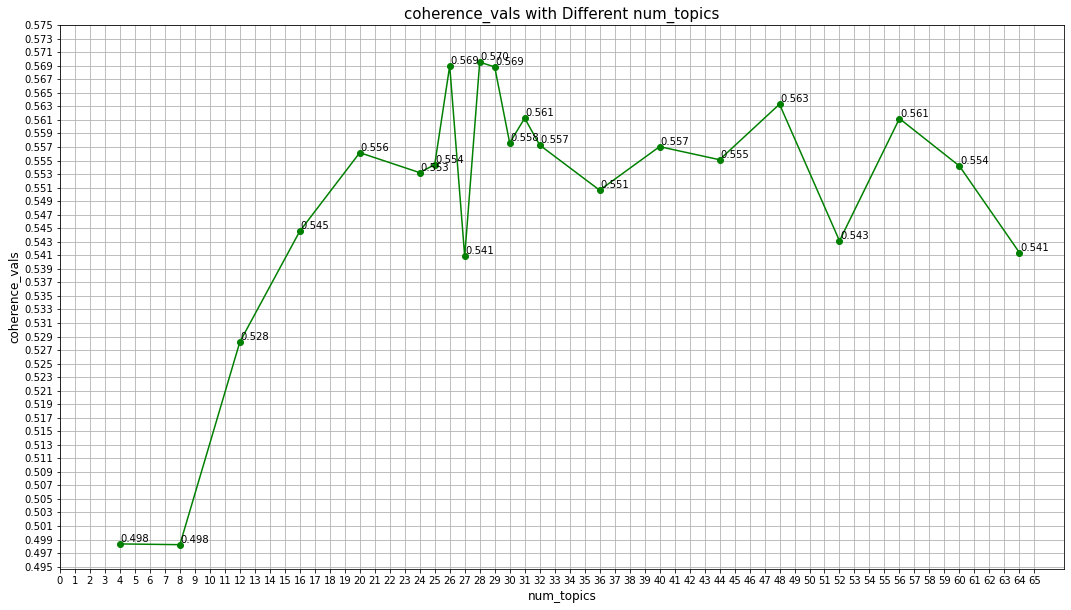

In [19]:
# source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# plot coherence_vals with Different num_topics
xs = np.r_[np.array(n_topics_1[:-2]), np.array(n_topics_3[0:3]), np.array(n_topics_1[-2]), np.array(n_topics_3[3:]), np.array(n_topics_1[-1]), np.array(n_topics_2)]
ys = np.r_[np.array(coherence_vals_1[:-2]), np.array(coherence_vals_3[0:3]), np.array(coherence_vals_1[-2]), np.array(coherence_vals_3[3:]), np.array(coherence_vals_1[-1]), np.array(coherence_vals_2)]
plt.figure(figsize=(18,10))
plt.plot(xs, ys, 'go-')  # 'bo-' means blue color, round points, (solid lines)
for x, y in zip(xs, ys):
    label = "{:.3f}".format(y)
    plt.annotate(label,  # this is the text
                 (x, y),  # this is the point to label
                 textcoords="offset points",  # how to position the text
                 xytext=(15, 2),  # distance from text to points (x,y)
                 ha='center',  # horizontal alignment can be left, right or center
                 fontsize=10)   
plt.title("coherence_vals with Different num_topics", fontsize=15)
plt.grid()
plt.xticks(ticks=(range(0,66)))
plt.yticks(ticks=np.linspace(0.495, 0.575, num=41))
plt.xlabel("num_topics", fontsize=12)
plt.ylabel("coherence_vals", fontsize=12)
plt.savefig('images/coh_2.png',orientation='landscape', facecolor='w',edgecolor='w',frameon=True)
plt.show()


In [20]:
# from the plot above, choose num_topics = 20 as it gives the highest coherence score
lda_model_final = lda_models_1['n_t_28']
pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[corpus]

[(27,
  '0.035*"test" + 0.029*"method" + 0.022*"result" + 0.018*"sample" + '
  '0.016*"time" + 0.014*"base" + 0.014*"use" + 0.012*"sensitivity" + '
  '0.010*"develop" + 0.010*"detection"'),
 (26,
  '0.085*"protein" + 0.022*"virus" + 0.019*"bind" + 0.017*"n" + 0.016*"domain" '
  '+ 0.016*"s" + 0.013*"pedv" + 0.011*"membrane" + 0.010*"acid" + '
  '0.009*"peptide"'),
 (25,
  '0.071*"virus" + 0.046*"influenza" + 0.036*"strain" + 0.017*"isolate" + '
  '0.017*"human" + 0.017*"pathogen" + 0.013*"bacterial" + 0.011*"bacteria" + '
  '0.010*"ibv" + 0.009*"infection"'),
 (24,
  '0.017*"health" + 0.014*"social" + 0.014*"research" + 0.012*"information" + '
  '0.009*"student" + 0.008*"medium" + 0.008*"participant" + 0.008*"experience" '
  '+ 0.008*"mental" + 0.008*"self"'),
 (23,
  '0.040*"vaccine" + 0.039*"cell" + 0.036*"response" + 0.031*"antibody" + '
  '0.028*"immune" + 0.026*"t" + 0.017*"antigen" + 0.013*"mouse" + '
  '0.012*"specific" + 0.011*"immunity"'),
 (22,
  '0.020*"high" + 0.015*"result

In [21]:
# Source: https://radimrehurek.com/gensim/auto_examples/howtos/run_compare_lda.html
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)
    plt.savefig('images/corr_plt.png',orientation='landscape', facecolor='w',edgecolor='w',frameon=True)

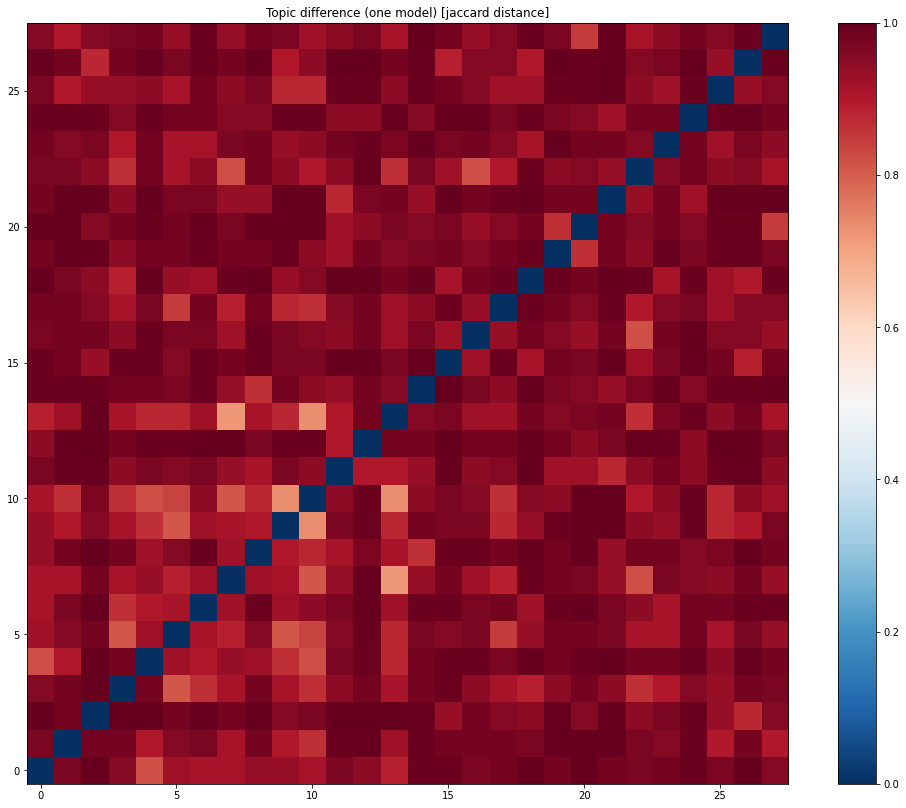

In [22]:
mdiff, annotation = lda_model_final.diff(lda_model_final, distance='jaccard', num_words=50)
plot_difference_matplotlib(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

In [23]:
# Visualize the topicskeywords
pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model_final, corpus, id2word)
# vis

In [24]:
# pyLDAvis.save_html(vis, 'saved_output/pyLDAvis/vis_lda.html')
# pyLDAvis.save_json(vis, 'saved_output/pyLDAvis/vis_lda.json')

In [25]:
# source: https://github.com/bmabey/pyLDAvis/issues/134
def prepared_data_from_dict(vis_data):
    topic_coordinates = pd.DataFrame.from_dict(vis_data['mdsDat'])
    topic_info = pd.DataFrame.from_dict(vis_data['tinfo'])
    token_table = pd.DataFrame.from_dict(vis_data['token.table'])
    R = vis_data['R']
    lambda_step = vis_data['lambda.step']
    plot_opts = vis_data['plot.opts']
    client_topic_order = vis_data['topic.order']
    return PreparedData(topic_coordinates, topic_info,
                        token_table, R, lambda_step, plot_opts, client_topic_order)

with open('saved_output/pyLDAvis/vis_lda.json', 'r') as json_file:
    dict_data = json.load(json_file)
    viz_data = prepared_data_from_dict(dict_data)
pyLDAvis.display(viz_data)

In [26]:
# source://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [27]:
# df_topic_sents_keywords = format_topics_sentences(lda_model_final, corpus, bodies)
# pickle.dump(df_topic_sents_keywords, open('saved_output/tables/df_topic_sents_keywords.pkl', 'wb'))
df_topic_sents_keywords = pickle.load(open('saved_output/tables/df_topic_sents_keywords.pkl', 'rb'))

# # create new columns
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# # show head of the new dataframe
df_dominant_topic.set_index('Document_No').head(10)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
Document_No,,,,
0,9.0,0.1613,"sars, cov-2, cov, coronavirus, mers, infection...","[december, outbreak, respiratory, disease, cau..."
1,17.0,0.1162,"specie, human, animal, host, study, pathogen, ...","[fossil, beautiful, provide, information, spec..."
2,23.0,0.2142,"vaccine, cell, response, antibody, immune, t, ...","[novel, coronavirus, describe, wuhan, china, d..."
3,12.0,0.2551,"care, health, medical, hospital, healthcare, n...","[emergence, novel, coronavirus, sars, cov-2, s..."
4,4.0,0.2706,"patient, clinical, respiratory, severe, pneumo...","[description, acute, respiratory, distress, sy..."
5,25.0,0.2203,"virus, influenza, strain, isolate, human, path...","[april, mexico, report, influenza, virus, outb..."
6,18.0,0.2082,"cell, expression, protein, viral, ifn, pathway...","[altered, expression, level, certain, gene, pl..."
7,26.0,0.1925,"protein, virus, bind, n, domain, s, pedv, memb...","[porcine, epidemic, diarrhoea, ped, viral, dis..."
8,2.0,0.3741,"rna, sequence, gene, virus, genome, viral, dna...","[classical, swine, fever, virus, csfv, highly,..."


In [28]:
def title_parser(df_dominant_topic, n):
    doc_nums = df_dominant_topic[df_dominant_topic['Dominant_Topic']==n].sort_values(by = 'Topic_Perc_Contrib', ascending=False)['Document_No'].values
    perc = df_dominant_topic[df_dominant_topic['Dominant_Topic']==n].sort_values(by = 'Topic_Perc_Contrib', ascending=False)['Topic_Perc_Contrib'].values
    titles = [pmc_entire_sample[doc_num]['title'][0] for doc_num in doc_nums[0:5]]
    pmc_nums = [pmc_entire_sample[doc_num]['title'][1] for doc_num in doc_nums[0:5]]
    topic_per = [round(x,3) for x in perc[0:5]]
    return titles, pmc_nums, topic_per

In [29]:
stats = pd.DataFrame({'Topic Number (n)':[n for n in range(28)], 'Number of Documents':[len(df_dominant_topic[df_dominant_topic['Dominant_Topic']==n]) for n in range(28)], '5 Document Titles with Topic Number, n, Being Most Dominant':[' ; '.join(title_parser(df_dominant_topic, n)[0]) for n in range(28)], 'PMC Num.':[title_parser(df_dominant_topic, n)[1] for n in range(28)], 'Topic_Perc_Contrib':[title_parser(df_dominant_topic, n)[2] for n in range(28)]})
stats.set_index('Topic Number (n)', inplace=True)
from pandas import option_context
with option_context('display.max_colwidth', -1):
    display(stats)

,Number of Documents,"5 Document Titles with Topic Number, n, Being Most Dominant",PMC Num.,Topic_Perc_Contrib
Topic Number (n),,,,
0,1198,A Rare Complication of Myocardial Infarction: Ventricular Septal Defect ; Minimally invasive beating heart technique for mitral valve surgery in patients with previous sternotomy and giant left ventricle ; COVID-19 Fears May Be Worse Than the Virus: A Case of Cardiogenic Shock Secondary to Post-Myocardial Infarction Ventricular Septum Rupture ; Abdominal compartment syndrome following posterior lumbar fusion in a patient with previous abdominal surgery ; Painless retrograde type A aortic dissection followed conservative treatment of type B aortic dissection: a case report,"[PMC7489448, PMC7268179, PMC7381854, PMC6786363, PMC6956508]","[0.574, 0.554, 0.536, 0.535, 0.522]"
1,1134,"Development and application of one-step multiplex reverse transcription PCR for simultaneous detection of five diarrheal viruses in adult cattle ; Survey of WU and KI polyomaviruses, coronaviruses, respiratory syncytial virus and parechovirus in children under 5 years of age in Tehran, Iran ; A multiplex one-tube nested real time RT-PCR assay for simultaneous detection of respiratory syncytial virus, human rhinovirus and human metapneumovirus ; Comparison of two multiplex PCR assays for the detection of respiratory viral infections ; Etiology of respiratory disease in non-vaccinated, non-medicated calves in rearing herds","[PMC7086690, PMC7244825, PMC6208169, PMC7162222, PMC7130506]","[0.531, 0.486, 0.469, 0.463, 0.461]"
2,923,RNA sequence and secondary structural determinants in a minimal viral promoter that directs replicase recognition and initiation of genomic plus-strand RNA synthesis1 ; Cis-acting Regulatory Elements in the Potato Virus X 3′ Non-translated Region Differentially Affect Minus-strand and Plus-strand RNA Accumulation ; A long-distance RNA–RNA interaction plays an important role in programmed − 1 ribosomal frameshifting in the translation of p88 replicase protein of Red clover necrotic mosaic virus ; Sequence requirements for RNA strand transfer during nidovirus discontinuous subgenomic RNA synthesis ; Analysis of intermolecular RNA–RNA recombination by rubella virus,"[PMC7172556, PMC7126608, PMC7111920, PMC125340, PMC7126107]","[0.613, 0.606, 0.604, 0.599, 0.577]"
3,399,Endogenous Cell Repair of Chronic Demyelination ; SIRT1 Activating compounds reduce oxidative stress mediated neuronal loss in viral induced CNS demyelinating disease ; High viral loads despite absence of clinical and pathological findings in cats experimentally infected with feline coronavirus (FCoV) type I and in naturally FCoV-infected cats ; Extracellular matrix in the CNS induced by neuropathogenic viral infection ; Microglia Play a Major Role in Direct Viral-Induced Demyelination,"[PMC1635791, PMC3892130, PMC7128724, PMC7168127, PMC3705805]","[0.468, 0.447, 0.424, 0.424, 0.418]"
4,1130,Lung Cancer with Diffuse Ground-glass Shadow in Two Lungs and Respiratory Failure ; 2019 Novel Coronavirus (COVID-19) Pneumonia with Hemoptysis as the Initial Symptom: CT and Clinical Features ; Clinical features and chest CT findings of three cases of 2019 novel coronavirus (COVID-2019) pneumonia ; Atypical Chest Computed Tomography Finding of Predominant Interstitial Thickening in a Patient with Coronavirus Disease 2019 (COVID-19) Pneumonia ; Imaging characteristics of initial chest computed tomography and clinical manifestations of patients with COVID-19 pneumonia,"[PMC4976580, PMC7183833, PMC7303668, PMC7520135, PMC7171599]","[0.539, 0.503, 0.485, 0.484, 0.484]"
5,223,Gefitinib sensitization of cisplatin-resistant wild-type EGFR non-small cell lung cancer cells ; Tumor Size as a Critical Prognostic Factor in T1-2 Stage Esophageal Cancer ; Interferon-Induced Transmembrane Protein 1 (IFITM1) Promotes Distant Metastasis of Small Cell Lung Cancer ; Potent delivery of an MMP inhibitor to the tumor microenvironment with thermosensitive liposomes 

In [30]:
stats.to_markdown();

In [40]:
topic_themes = pd.DataFrame({'Infered Topic Themes':["Various surgical procedures complications and outcomes", "Testing and detecting for virus infections (PCR)", "Studies into viral RNA strands", "Effect of virus infections at the cellular level", "COVID-19: and resulting/interaction respiratory infection", "Studies into Lung/Breast cancer", "Lung injuries resulting from various other diseases", "COVID-19: studies into risk factors which exacerbate its symptoms", "COVID-19: Transmission and spread prevention measures", "Studies into other coronavirus infections (e.g. COV-2, SARS, MERS)", "No clear theme in the topic, related to different studies into viruses", "Reviews and assessments into medical publications", "COVID-19: effect of the pandameic on medical practices", "Studies into obstetric procedures which includes complications from COVID-19","Travel and spread of pandemics including COVID-19", "Medical chemistry and biochemestry research", "Studies into dispersion of airborne/aerosol particles","Viral transmission between humans and animals", "Cellular and molecular immunology", "Mathematical modelling which touch on COVID19 modelling", "Data engineering and science papers", "Economic implications of panademics and other factors on various business sectors", "COVID-19: Global effect on communities","Vaccines", "Education", "Genetics and viral infections", "Biochemical studies related to viral infections", "Testing and diagnosis of viral infections"]})

In [47]:
# Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorted_df = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index
sent_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted_df.columns = ['Topic Num (n)', "Topic Perc. Contrib.", "Keywords of the paper with topic n being most dominant", "Text"]
lda_topics_df = pd.concat([sent_topics_sorted_df.set_index('Topic Num (n)')[["Topic Perc. Contrib.", "Keywords of the paper with topic n being most dominant"]], topic_themes], axis=1)
# show head of the new dataframe
with option_context('display.max_colwidth', -1):
    display(lda_topics_df)

,Topic Perc. Contrib.,Keywords of the paper with topic n being most dominant,Infered Topic Themes
0.0,0.5738,"patient, covid-19, risk, mortality, icu, outcome, complication, covid‐19, surgery, high",Various surgical procedures complications and outcomes
1.0,0.5308,"virus, sample, child, respiratory, pcr, detect, detection, viral, study, infection",Testing and detecting for virus infections (PCR)
2.0,0.6127,"rna, sequence, gene, virus, genome, viral, dna, bat, region, mutation",Studies into viral RNA strands
3.0,0.4681,"cell, tissue, type, study, mouse, effect, increase, cat, show, result",Effect of virus infections at the cellular level
4.0,0.5390,"patient, clinical, respiratory, severe, pneumonia, symptom, covid-19, case, diagnosis, ct",COVID-19: and resulting/interaction respiratory infection
5.0,0.4056,"drug, treatment, study, cancer, effect, hiv, potential, target, agent, development",Studies into Lung/Breast cancer
6.0,0.4607,"inflammatory, cytokine, level, lung, disease, increase, treatment, inflammation, liver, blood",Lung injuries resulting from various other diseases
7.0,0.3791,"population, study, age, high, rate, datum, factor, individual, year, risk",COVID-19: studies into risk factors which exacerbate its symptoms
8.0,0.4098,"covid-19, case, pandemic, transmission, risk, contact, spread, measure, outbreak, confirm",COVID-19: Transmission and spread prevention measures
9.0,0.4416,"sars, cov-2, cov, coronavirus, mers, infection, virus, human, viral, syndrome","Studies into other coronavirus infections (e.g. COV-2, SARS, MERS)"


In [48]:
lda_topics_df.to_markdown();

# Mallet and Gensim LDA

In [47]:
import os
os.environ['MALLET_HOME'] = r'C:/Users/omarq/Mallet/mallet-2.0.8'

In [48]:
# Build LDA model with different num_topics
mallet_path = r'C:/Users/omarq/Mallet/mallet-2.0.8/bin/mallet'
def lda_models_iterations_mallet(n_topics, id2word, corpus):
    lda_models = {}
    for n in tqdm(n_topics):
        start_t = time.time()
        lda_models['n_t_'+str(n)] = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=n, id2word=id2word, workers=4, random_seed=81)
        end_t = time.time()
        elapsed_t = end_t- start_t
        print(str(int(elapsed_t)//60//60)+':'+str(int(elapsed_t)//60%60)+':'+str(int(elapsed_t)%60), end='\n')
    return lda_models

In [49]:
n_topics_mallet = list(range(4,65,4))

In [50]:
# lda_mallet = lda_models_iterations_mallet(n_topics_mallet, id2word, corpus)
# # pre-saved models can be loaded here
# pickle.dump(lda_mallet, open('saved_output/lda_models/lda_models_mallet.pkl', 'wb'))
lda_mallet = pickle.load(open('saved_output/lda_models/lda_models_mallet.pkl', 'rb'))

In [51]:
# coherence_vals_m, vals_diff_topics_df_m = calculate_coherence_vals(lda_mallet, n_topics_mallet, bodies, id2word)
# # Save output and Load pre-saved coherence score results
# pickle.dump(vals_diff_topics_df_m, open('saved_output/coherence/vals_diff_topics_df_m.pkl', 'wb'))
# pickle.dump(coherence_vals_m, open('saved_output/coherence/coherence_vals_m.pkl', 'wb'))
coherence_vals_m = pickle.load(open('saved_output/coherence/coherence_vals_m.pkl', 'rb'))
vals_diff_topics_df_m = pickle.load(open('saved_output/coherence/vals_diff_topics_df_m.pkl', 'rb'))

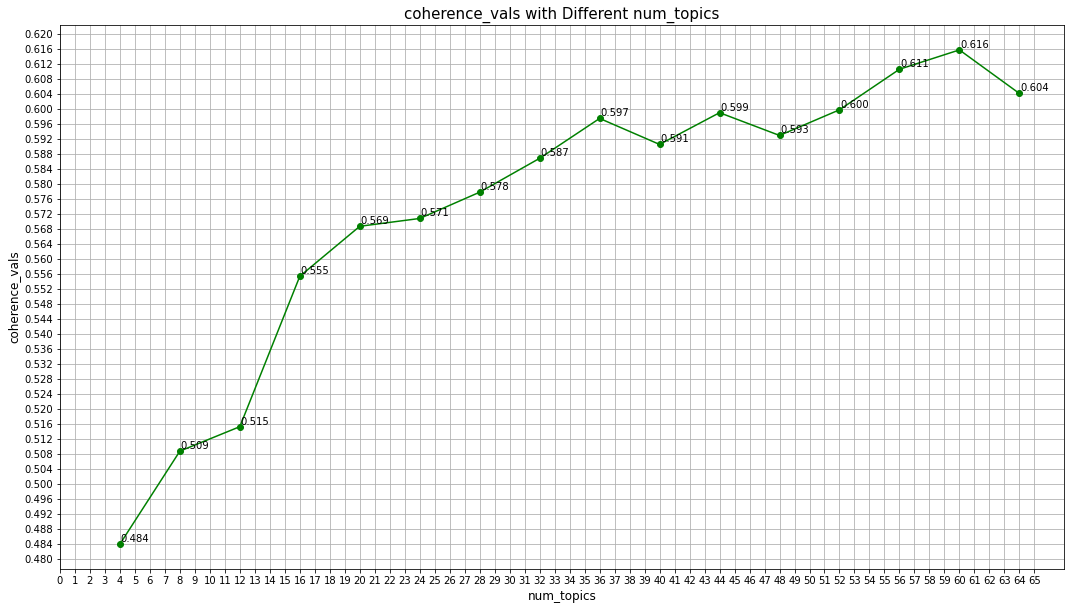

In [52]:
# source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# plot coherence_vals with Different num_topics
xs = np.array(n_topics_mallet)
ys = np.array(coherence_vals_m)
plt.figure(figsize=(18,10))
plt.plot(xs, ys, 'go-')
for x, y in zip(xs, ys):
    label = "{:.3f}".format(y)
    plt.annotate(label,  # this is the text
                 (x, y),  # this is the point to label
                 textcoords="offset points",  # how to position the text
                 xytext=(15, 2),  # distance from text to points (x,y)
                 ha='center',  # horizontal alignment can be left, right or center
                 fontsize=10)   
plt.title("coherence_vals with Different num_topics", fontsize=15)
plt.grid()
plt.xticks(ticks=(range(0,66)))
plt.yticks(ticks=np.linspace(0.480, 0.620, num=36))
plt.xlabel("num_topics", fontsize=12)
plt.ylabel("coherence_vals", fontsize=12)
plt.savefig('images/coh_m.png',orientation='landscape', facecolor='w',edgecolor='w',frameon=True)
plt.show()

In [53]:
# from the plot above, choose num_topics = 20 as it gives the highest coherence score
lda_model_fm = lda_mallet['n_t_60']
pprint(lda_model_fm.print_topics())
# doc_lda_m = lda_model_fm[corpus]
# pickle.dump(doc_lda_m, open('saved_output/other/doc_lda_m.pkl', 'wb'))
doc_lda_m = pickle.load(open('saved_output/other/doc_lda_m.pkl', 'rb'))

[(58,
  '0.111*"cov" + 0.062*"mers" + 0.034*"coronavirus" + 0.033*"human" + '
  '0.026*"virus" + 0.024*"sars" + 0.022*"coronaviruse" + 0.020*"respiratory" + '
  '0.016*"infection" + 0.013*"hcov"'),
 (17,
  '0.033*"detection" + 0.032*"pcr" + 0.031*"assay" + 0.024*"sample" + '
  '0.021*"method" + 0.018*"rt" + 0.016*"sensitivity" + 0.016*"detect" + '
  '0.014*"time" + 0.013*"test"'),
 (14,
  '0.063*"model" + 0.015*"time" + 0.013*"network" + 0.013*"disease" + '
  '0.012*"individual" + 0.012*"dynamic" + 0.012*"number" + 0.012*"estimate" + '
  '0.011*"population" + 0.010*"datum"'),
 (32,
  '0.054*"test" + 0.038*"positive" + 0.028*"sample" + 0.026*"testing" + '
  '0.023*"infection" + 0.023*"symptom" + 0.021*"patient" + 0.021*"covid‐19" + '
  '0.018*"negative" + 0.018*"study"'),
 (45,
  '0.037*"patient" + 0.028*"ct" + 0.026*"case" + 0.023*"pneumonia" + '
  '0.022*"disease" + 0.021*"diagnosis" + 0.020*"clinical" + 0.019*"lung" + '
  '0.016*"finding" + 0.015*"chest"'),
 (2,
  '0.069*"antibody" +

In [54]:
# source://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
def format_topics_sentences_m(ldamodel, doc_lda, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(doc_lda):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [55]:
# df_topic_sents_keywords_m = format_topics_sentences_m(lda_model_fm, doc_lda_m, corpus, bodies)
# pickle.dump(df_topic_sents_keywords_m, open('saved_output/tables/df_topic_sents_keywords_m.pkl', 'wb'))
df_topic_sents_keywords_m = pickle.load(open('saved_output/tables/df_topic_sents_keywords_m.pkl', 'rb'))

# # create new columns
df_dominant_topic_m = df_topic_sents_keywords_m.reset_index()
df_dominant_topic_m.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# # show head of the new dataframe
df_dominant_topic_m.set_index('Document_No').head(10)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
Document_No,,,,
0,13.0,0.1291,"water, concentration, product, high, °, inacti...","[december, outbreak, respiratory, disease, cau..."
1,40.0,0.4560,"specie, area, water, sp, environmental, fish, ...","[fossil, beautiful, provide, information, spec..."
2,2.0,0.2931,"antibody, protein, epitope, peptide, antigen, ...","[novel, coronavirus, describe, wuhan, china, d..."
3,57.0,0.5226,"patient, surgery, hospital, surgical, care, pr...","[emergence, novel, coronavirus, sars, cov-2, s..."
4,4.0,0.3718,"patient, ventilation, lung, pressure, respirat...","[description, acute, respiratory, distress, sy..."
5,8.0,0.2797,"influenza, virus, pandemic, h1n1, human, infec...","[april, mexico, report, influenza, virus, outb..."
6,52.0,0.3646,"cell, protein, expression, gene, express, vect...","[altered, expression, level, certain, gene, pl..."
7,10.0,0.4250,"pedv, virus, pig, ibv, strain, prrsv, chicken,...","[porcine, epidemic, diarrhoea, ped, viral, dis..."
8,1.0,0.4752,"rna, sequence, structure, strand, site, genome...","[classical, swine, fever, virus, csfv, highly,..."


In [56]:
stats_m = pd.DataFrame({'Topic Number (n)':[n for n in range(60)], 'Number of Documents':[len(df_dominant_topic_m[df_dominant_topic_m['Dominant_Topic']==n]) for n in range(60)], '5 Document Titles with Topic Number, n, Being Most Dominant':[' ; '.join(title_parser(df_dominant_topic_m, n)[0]) for n in range(60)], 'PMC Num.':[title_parser(df_dominant_topic_m, n)[1] for n in range(60)], 'Topic_Perc_Contrib':[title_parser(df_dominant_topic_m, n)[2] for n in range(60)]})
stats_m.set_index('Topic Number (n)', inplace=True)
from pandas import option_context
with option_context('display.max_colwidth', -1):
    display(stats_m)

,Number of Documents,"5 Document Titles with Topic Number, n, Being Most Dominant",PMC Num.,Topic_Perc_Contrib
Topic Number (n),,,,
0,324,α2-3- and α2-6- N-linked sialic acids allow efficient interaction of Newcastle Disease Virus with target cells ; An exploration of conditions proposed to trigger the Ebola virus glycoprotein for fusion ; Calu-3 cells are largely resistant to entry driven by filovirus glycoproteins and the entry defect can be rescued by directed expression of DC-SIGN or cathepsin L ; Direct Visualization of Ebola Virus Fusion Triggering in the Endocytic Pathway ; High-Mannose Specific Lectin and Its Recombinants from a Carrageenophyta Kappaphycus alvarezii Represent a Potent Anti-HIV Activity Through High-Affinity Binding to the Viral Envelope Glycoprotein gp120,"[PMC7088266, PMC6611598, PMC7112014, PMC4752599, PMC7088233]","[0.78, 0.738, 0.725, 0.698, 0.687]"
1,268,Cis-acting Regulatory Elements in the Potato Virus X 3′ Non-translated Region Differentially Affect Minus-strand and Plus-strand RNA Accumulation ; A long-distance RNA–RNA interaction plays an important role in programmed − 1 ribosomal frameshifting in the translation of p88 replicase protein of Red clover necrotic mosaic virus ; Sequence requirements for RNA strand transfer during nidovirus discontinuous subgenomic RNA synthesis ; mRNA-Mediated Duplexes Play Dual Roles in the Regulation of Bidirectional Ribosomal Frameshifting ; The 3′-Terminal 55 Nucleotides of Bovine Coronavirus Defective Interfering RNA Harbor Cis-Acting Elements Required for Both Negative- and Positive-Strand RNA Synthesis,"[PMC7126608, PMC7111920, PMC125340, PMC6321510, PMC4031142]","[0.891, 0.862, 0.847, 0.831, 0.819]"
2,336,"Maturation Pathways of Cross-Reactive HIV-1 Neutralizing Antibodies ; Conserved amino acids W423 and N424 in receptor-binding domain of SARS-CoV are potential targets for therapeutic monoclonal antibody ; The Antibody Germline/Maturation Hypothesis, Elicitation of Broadly Neutralizing Antibodies Against HIV-1 and Cord Blood IgM Repertoires ; Assessment of antibody responses against gp41 in HIV-1-infected patients using soluble gp41 fusion proteins and peptides derived from M group consensus envelope ; Divergent Peptide Presentations of HLA-A*30 Alleles Revealed by Structures With Pathogen Peptides","[PMC3185542, PMC7103409, PMC4147355, PMC2293309, PMC6664060]","[0.616, 0.602, 0.59, 0.582, 0.57]"
3,338,The CC chemokine ligand 3 regulates CD11c+CD11b+CD8α− dendritic cell maturation and activation following viral infection of the central nervous system: implications for a role in T cell activation ; IL-15-independent antiviral function of primary and memory CD8+ T cells ; IL-15 independent maintenance of virus-specific CD8+ T cells in the CNS during chronic infection ; Exacerbation of Japanese Encephalitis by CD11chi Dendritic Cell Ablation Is Associated with an Imbalance in Regulatory Foxp3+ and IL-17+CD4+ Th17 Cells and in Ly-6Chi and Ly-6Clo Monocytes ; Memory T-cell competition for bone marrow seeding,"[PMC7111789, PMC7111818, PMC2679951, PMC5484650, PMC1782895]","[0.827, 0.778, 0.763, 0.734, 0.728]"
4,353,Efficacy and safety of early prone positioning combined with HFNC or NIV in moderate to severe ARDS: a multi-center prospective cohort study ; Neurally adjusted ventilatory assist preserves cerebral blood flow velocity in patients recovering from acute brain injury ; Peripheral perfusion index as a predictor of failed weaning from mechanical ventilation ; Assessment of the benefits of head-up preoxygenation using near-infrared spectroscopy with pulse oximetry in a swine model ; Initial emergency department mechanical ventilation strategies for COVID-19 hypoxemic respiratory failure and ARDS,"[PMC6993481, PMC7223974, PMC7224046, PMC7223107, PMC7335247]","[0.717, 0.716, 0.689, 0.683, 0.682]"
5,544,Relevance Ranking Based on Query-Aware Context Analysis ; Joint Word and Entity Embeddings for Entity Retrieval from a Knowledge Graph ; To BERT or Not to B

In [57]:
# print(stats_m.to_markdown())

In [58]:
# Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorted_df_m = pd.DataFrame()

sent_topics_outdf_grpd_m = df_topic_sents_keywords_m.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_m:
    sent_topics_sorted_df_m = pd.concat([sent_topics_sorted_df_m, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index
sent_topics_sorted_df_m.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted_df_m.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# show head of the new dataframe
sent_topics_sorted_df_m.set_index('Topic_Num')

,Topic_Perc_Contrib,Keywords,Text
Topic_Num,,,
0.0,0.7796,"cell, receptor, fusion, entry, bind, protein, ...","[initial, step, virus, entry, host, cell, cons..."
1.0,0.8907,"rna, sequence, structure, strand, site, genome...","[replication, viral, rna, eucaryotic, procaryo..."
2.0,0.6158,"antibody, protein, epitope, peptide, antigen, ...","[elicitation, broadly, cross, reactive, hiv-1,..."
3.0,0.8274,"cell, mouse, infection, immune, response, cd8,...","[cc, chemokine, ligand, ccl3—macrophage, infla..."
4.0,0.7167,"patient, ventilation, lung, pressure, respirat...","[acute, respiratory, distress, syndrome, ards,..."
5.0,0.7788,"model, datum, method, base, performance, propo...","[basic, retrieval, model, bm25, language, mode..."
6.0,0.5427,"treatment, drug, clinical, effect, trial, ther...","[december, world, health, organization, office..."
7.0,0.8022,"research, health, public, policy, social, comm...","[civil, society, activism, lead, social, chang..."
8.0,0.5259,"influenza, virus, pandemic, h1n1, human, infec...","[influenza, virus, affect, people, age, cause,..."
